# Preprocessing and splitting the breast cancer dataset

## Load the data and remove duplicates

In [1]:
import json
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import KFold

In [2]:
data = pd.read_excel('Breast_cancer_data.xlsx').set_index('Patient ID')

In [3]:
data.shape

(1918, 20)

Some patients had biopsies from more than one location, so appear more than once in the original Table S2 spreadsheet and hence in our condensed table. We only keep the first occurrence.

In [4]:
print(data.index.duplicated().sum())
print(data.index[data.index.duplicated()])

162
Index(['P-0000066', 'P-0000081', 'P-0000104', 'P-0000138', 'P-0000152',
       'P-0000153', 'P-0000167', 'P-0000204', 'P-0000216', 'P-0000234',
       ...
       'P-0014703', 'P-0015063', 'P-0015116', 'P-0016093', 'P-0016335',
       'P-0016689', 'P-0016816', 'P-0016840', 'P-0017261', 'P-0018675'],
      dtype='object', name='Patient ID', length=162)


In [5]:
data_no_dupl = data[~data.index.duplicated(keep='first')]
data_no_dupl.shape

(1756, 20)

In [6]:
missing_val = ['Not Available', 'unk', 'Unk/ND', 'UNk/ND', 'Unknown']
data_no_dupl = data_no_dupl.replace(missing_val, np.nan)

In [7]:
outcome_columns = [
    'Disease Free Event',
    'Disease Free (Months)',
    'Overall Survival (Months)',
    'Overall Survival Status'
]

#### Introduce Synthetic MAR informative missingness

uses 'Overall Survival Status' as the label

In [8]:
predictors = [list(data_no_dupl).index(c) for c in list(data_no_dupl) if c not in outcome_columns]

In [9]:
cts_predictors = [index for index in predictors if data_no_dupl.dtypes[index] == np.dtype('float64')]

In [10]:
added_missingness_num_cols = 1
added_missingness_rate = 0.4
np.random.seed(0)

target_cols = np.array([0])#np.random.choice(predictors, added_missingness_num_cols, replace=False)

inter_cols = np.array([1])#np.random.choice(cts_predictors, added_missingness_num_cols, replace=False)
targets = np.random.choice([0, 1], size=(data_no_dupl.shape[0], target_cols.shape[0]), p=[1-added_missingness_rate, added_missingness_rate])

for i, col in enumerate(target_cols):
    print(f"Adding missingness to: {data_no_dupl.columns[col]}")
    thresh_col = data_no_dupl.columns[inter_cols[i]]
    thresh_mask = data_no_dupl[thresh_col] >= data_no_dupl[thresh_col].quantile(0.6)
    tartget_labels = np.zeros_like(thresh_mask)
    tartget_labels[thresh_mask] = 1
    mask = (targets[:, i] == 1) & ((data_no_dupl['Overall Survival Status'] == '1:DECEASED') == tartget_labels)
    data_no_dupl.loc[mask, data_no_dupl.columns[col]] = np.nan

Adding missingness to: Disease Free Event


#### Return to loading and processing data

In [11]:
outcomes = data_no_dupl[outcome_columns]
features = data_no_dupl.drop(columns=outcome_columns)

In [12]:
data_no_dupl.isnull().sum()

Disease Free Event                      225
Disease Free (Months)                     0
ER Status of the Primary                 27
Fraction Genome Altered                  22
Invasive Carcinoma Diagnosis Age          0
Metastatic Disease at Last Follow-up      0
Metastatic Recurrence Time              495
Mutation Count                           79
M Stage                                   0
N Stage                                   6
Oncotree Code                             0
Overall Survival (Months)                 0
Overall Survival Status                   0
Overall Patient HER2 Status               0
Overall Patient HR Status                 0
Overall Patient Receptor Status           0
Overall Primary Tumor Grade             173
PR Status of the Primary                 40
Stage At Diagnosis                       13
T Stage                                  13
dtype: int64

In [13]:
(features == 'unk').sum()

ER Status of the Primary                0
Fraction Genome Altered                 0
Invasive Carcinoma Diagnosis Age        0
Metastatic Disease at Last Follow-up    0
Metastatic Recurrence Time              0
Mutation Count                          0
M Stage                                 0
N Stage                                 0
Oncotree Code                           0
Overall Patient HER2 Status             0
Overall Patient HR Status               0
Overall Patient Receptor Status         0
Overall Primary Tumor Grade             0
PR Status of the Primary                0
Stage At Diagnosis                      0
T Stage                                 0
dtype: int64

In [14]:
features.isnull().sum()

ER Status of the Primary                 27
Fraction Genome Altered                  22
Invasive Carcinoma Diagnosis Age          0
Metastatic Disease at Last Follow-up      0
Metastatic Recurrence Time              495
Mutation Count                           79
M Stage                                   0
N Stage                                   6
Oncotree Code                             0
Overall Patient HER2 Status               0
Overall Patient HR Status                 0
Overall Patient Receptor Status           0
Overall Primary Tumor Grade             173
PR Status of the Primary                 40
Stage At Diagnosis                       13
T Stage                                  13
dtype: int64

## Encode categorical and ordinal columns

We temporarily include yes/no (or similar) columns in the ordinal columns list, as we reserve the categorical columns for those which we will one-hot encode.

In [15]:
cols_cat = ['Oncotree Code', 'Overall Patient Receptor Status']

cols_ordinal = [
    'ER Status of the Primary',
    'Metastatic Disease at Last Follow-up',
    'M Stage',
    'N Stage',
    'Overall Patient HER2 Status',
    'Overall Patient HR Status',
    'Overall Primary Tumor Grade',
    'PR Status of the Primary',
    'Stage At Diagnosis',
    'T Stage'
]

features_cat = features[cols_cat]
features_ordinal = features[cols_ordinal]
features_numerical = features.drop(columns = cols_ordinal + cols_cat).convert_dtypes()

cols_outcome_cat = ['Overall Survival Status']

outcomes_cat = outcomes[cols_outcome_cat]
outcomes_numerical = outcomes.drop(columns = cols_outcome_cat).convert_dtypes()

In [16]:
for col in cols_ordinal:
    print(col, features_ordinal[col].unique())

ER Status of the Primary ['Positive' 'Negative' nan]
Metastatic Disease at Last Follow-up ['Yes' 'No']
M Stage ['M1' 'M0']
N Stage ['N3a' 'N0' 'N1mi' 'NX' 'N1a' 'N2a' 'N1' 'N3c' 'N2b' 'N3b' 'N1c' nan 'N3'
 'N0(i+)' 'N2' 'N1b']
Overall Patient HER2 Status ['Negative' 'Positive']
Overall Patient HR Status ['Positive' 'Negative']
Overall Primary Tumor Grade ['II  Intermediate Grade (Moderately Differentiated)'
 'III High Grade (Poorly Differentiated)'
 'I  Low Grade (Well Differentiated)' nan]
PR Status of the Primary ['Positive' 'Negative' nan]
Stage At Diagnosis ['IV' 'IIA' 'IB' 'IA' 'IIIA' 'IIIC' 'IIB' 'IIIB' nan]
T Stage ['T1c' 'T2' 'T1b' 'TX' 'T3' 'T1a' 'T4c' 'T4b' 'T4a' 'T4d' nan 'T0' 'T1mi'
 'T4' 'T1' 'Tis' 'T1C']


In [17]:
features_ordinal.isnull().sum()

ER Status of the Primary                 27
Metastatic Disease at Last Follow-up      0
M Stage                                   0
N Stage                                   6
Overall Patient HER2 Status               0
Overall Patient HR Status                 0
Overall Primary Tumor Grade             173
PR Status of the Primary                 40
Stage At Diagnosis                       13
T Stage                                  13
dtype: int64

In [18]:
features_ordinal = features_ordinal.replace({
    'ER Status of the Primary': {
        'Positive': 1,
        'Negative': 0,
    },
    'Metastatic Disease at Last Follow-up': {
        'Yes': 1,
        'No': 0,
    },
    'M Stage': {
        'M1': 1,
        'M0': 0,
    },
    'N Stage': {
        'N0': 0, 'N0(i+)': 0, 'NX': 0,
        'N1': 1, 'N1a': 1, 'N1b': 1, 'N1c': 1, 'N1mi': 1,
        'N2': 2, 'N2a': 2, 'N2b': 2,
        'N3': 3, 'N3a': 3, 'N3b': 3, 'N3c': 3,
    },
    'Overall Patient HER2 Status': {
        'Positive': 1,
        'Negative': 0,
    },
    'Overall Patient HR Status': {
        'Positive': 1,
        'Negative': 0,
    },
    'Overall Primary Tumor Grade': {
        'I  Low Grade (Well Differentiated)': 1,
        'II  Intermediate Grade (Moderately Differentiated)': 2,
        'III High Grade (Poorly Differentiated)': 3,
    },
    'PR Status of the Primary': {
        'Positive': 1,
        'Negative': 0,
    },
    'Stage At Diagnosis': {
        'IA': 1, 'IB': 2, 'IIA': 3, 'IIB': 4,
        'IIIA': 5, 'IIIB': 6, 'IIIC': 7, 'IV': 8,
    },
    'T Stage': {
        'T0': 0, 'Tis': 0, 'TX': 0,
        'T1': 1, 'T1a': 1, 'T1b': 1, 'T1c': 1, 'T1C': 1, 'T1mi': 1,
        'T2': 2,
        'T3': 3,
        'T4': 4, 'T4a': 4, 'T4b': 4, 'T4c': 4, 'T4d': 4,
    },
})
features_ordinal = features_ordinal.convert_dtypes()

In [19]:
features_ordinal

,ER Status of the Primary,Metastatic Disease at Last Follow-up,M Stage,N Stage,Overall Patient HER2 Status,Overall Patient HR Status,Overall Primary Tumor Grade,PR Status of the Primary,Stage At Diagnosis,T Stage
Patient ID,,,,,,,,,,
P-0000004,1,1,1,3,0,1,2,1,8,1
P-0000012,0,0,0,0,0,0,3,0,3,2
P-0000015,1,1,0,1,0,1,3,1,2,1
P-0000041,1,1,0,0,1,1,3,1,1,1
P-0000057,1,1,1,0,0,1,2,1,8,0
...,...,...,...,...,...,...,...,...,...,...
P-0018917,1,0,0,0,0,1,2,1,1,1
P-0018963,1,0,0,0,0,1,2,1,1,1
P-0019037,1,0,0,0,0,1,2,0,1,1


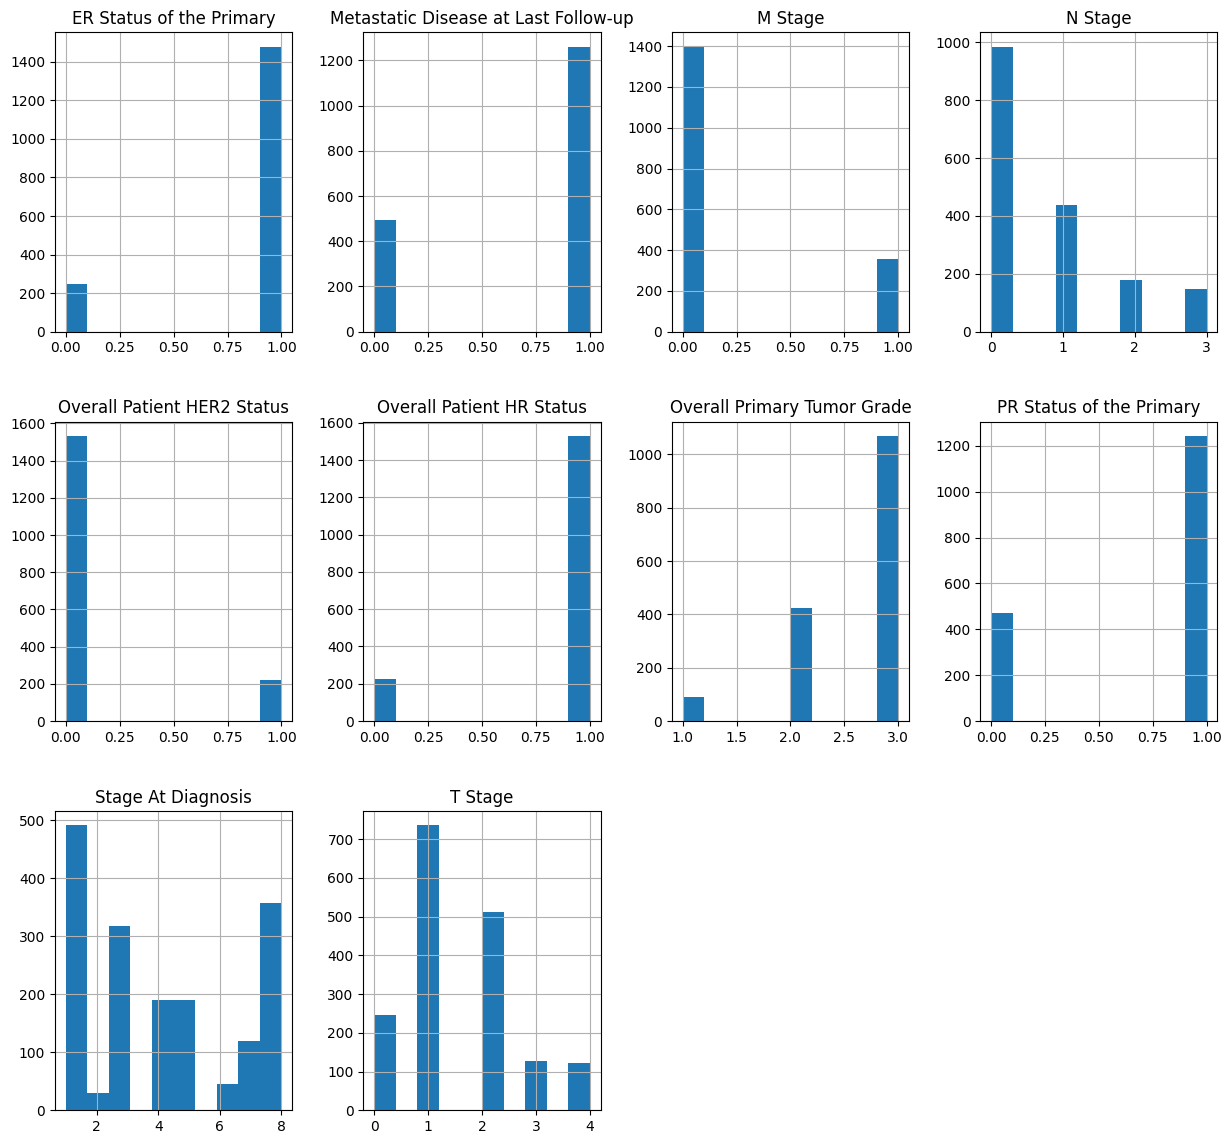

In [20]:
features_ordinal.hist(figsize=(15, 14), layout=(3, 4));

In [21]:
outcomes_cat = outcomes_cat.replace({'Overall Survival Status': {'0:LIVING': 0, '1:DECEASED': 1}})

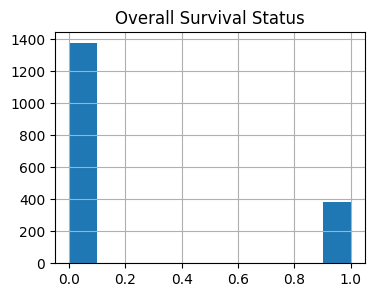

In [22]:
outcomes_cat.hist(figsize=(4, 3));

For categorical values in the input features, we use one-hot encoding. We first check that we have no missing data here.

In [23]:
features_cat.isnull().sum()

Oncotree Code                      0
Overall Patient Receptor Status    0
dtype: int64

In [24]:
ohe = OneHotEncoder(sparse=False, dtype=int)
cat_array = ohe.fit_transform(features_cat)
feature_labels = ohe.get_feature_names_out(['Oncotree Code', 'Overall Patient Receptor Status'])
features_cat_onehot = pd.DataFrame(cat_array, columns=feature_labels, index = features_numerical.index)

In [25]:
features_cat_onehot

,Oncotree Code_ACBC,Oncotree Code_BRCA,Oncotree Code_BRCANOS,Oncotree Code_BREAST,Oncotree Code_IDC,Oncotree Code_ILC,Oncotree Code_IMMC,Oncotree Code_MBC,Oncotree Code_MDLC,Overall Patient Receptor Status_HR+/HER2+,Overall Patient Receptor Status_HR+/HER2-,Overall Patient Receptor Status_HR-/HER2+,Overall Patient Receptor Status_Triple Negative
Patient ID,,,,,,,,,,,,,
P-0000004,0,0,0,0,1,0,0,0,0,0,1,0,0
P-0000012,0,0,0,0,1,0,0,0,0,0,0,0,1
P-0000015,0,0,0,0,1,0,0,0,0,0,1,0,0
P-0000041,0,0,0,0,1,0,0,0,0,1,0,0,0
P-0000057,0,0,0,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
P-0018917,0,0,0,0,1,0,0,0,0,0,1,0,0
P-0018963,0,0,0,0,1,0,0,0,0,0,1,0,0
P-0019037,0,0,0,0,1,0,0,0,0,0,1,0,0


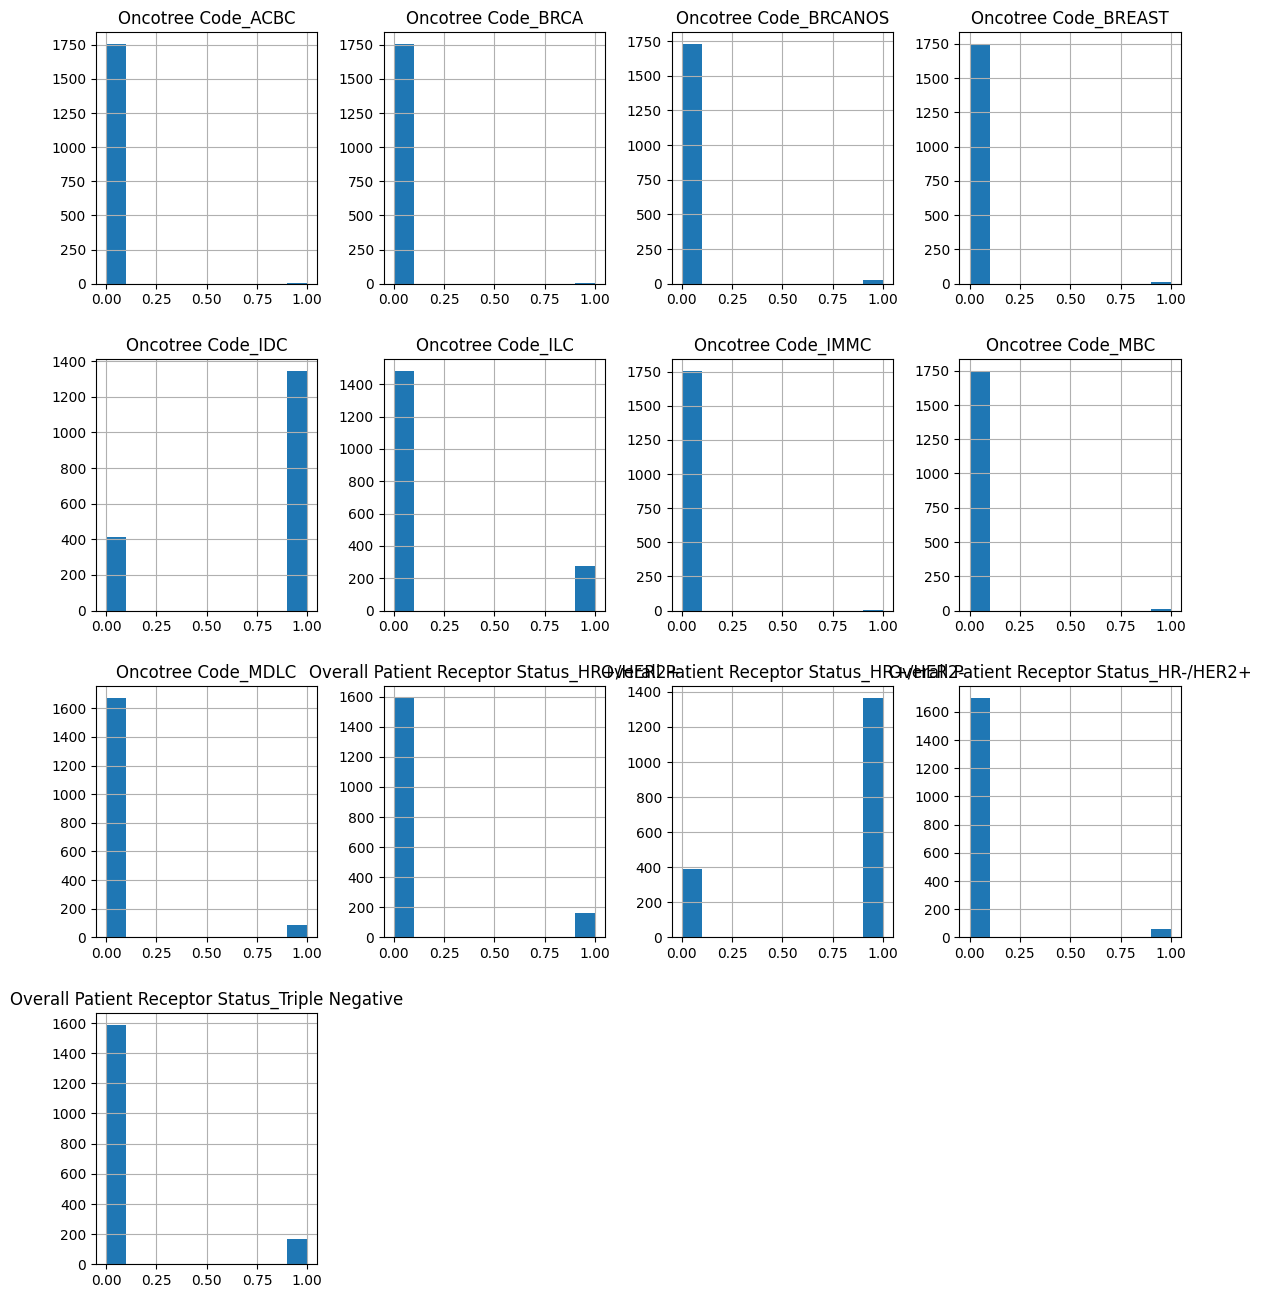

In [26]:
features_cat_onehot.hist(figsize=(14, 16));

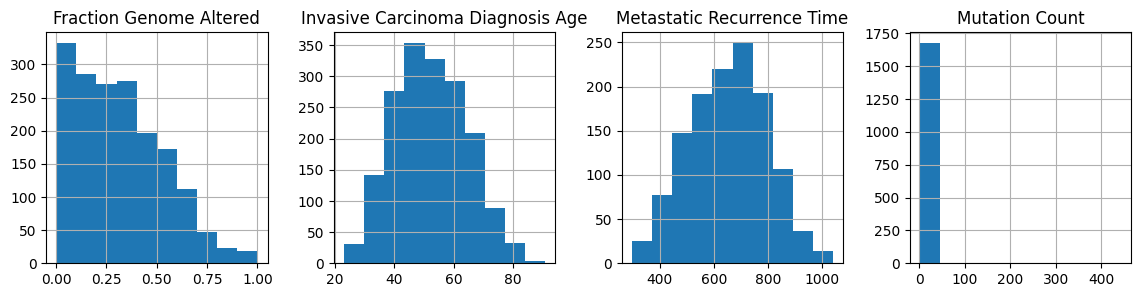

In [27]:
features_numerical.hist(figsize=(14, 3), layout=(1, 4));

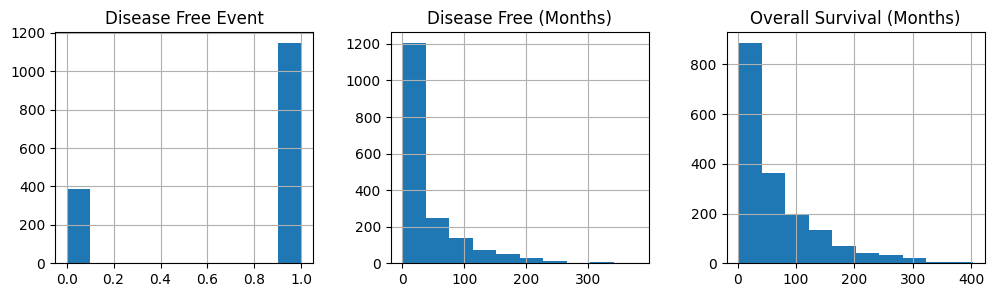

In [28]:
outcomes_numerical.hist(figsize=(12,3), layout=(1, 3));

### Collect into a single DataFrame

Note that we only use the single categorical outcome measure: Overall Survival Status.  We create two combined DataFrames, one with one-hot encoding and one without.

In [29]:
breast_features_onehot = features_numerical.join([features_cat_onehot, features_ordinal])
breast_df_onehot = pd.concat([breast_features_onehot, outcomes_cat], axis=1)

breast_features = features_numerical.join([features_cat, features_ordinal])
breast_df = pd.concat([breast_features, outcomes_cat], axis=1)

In [30]:
breast_df

,Fraction Genome Altered,Invasive Carcinoma Diagnosis Age,Metastatic Recurrence Time,Mutation Count,Oncotree Code,Overall Patient Receptor Status,ER Status of the Primary,Metastatic Disease at Last Follow-up,M Stage,N Stage,Overall Patient HER2 Status,Overall Patient HR Status,Overall Primary Tumor Grade,PR Status of the Primary,Stage At Diagnosis,T Stage,Overall Survival Status
Patient ID,,,,,,,,,,,,,,,,,
P-0000004,<NA>,37,446,4,IDC,HR+/HER2-,1,1,1,3,0,1,2,1,8,1,0
P-0000012,0.6891,43,<NA>,1,IDC,Triple Negative,0,0,0,0,0,0,3,0,3,2,0
P-0000015,<NA>,37,519,7,IDC,HR+/HER2-,1,1,0,1,0,1,3,1,2,1,1
P-0000041,0.6367,43,604,10,IDC,HR+/HER2+,1,1,0,0,1,1,3,1,1,1,1
P-0000057,0.5093,38,459,5,MDLC,HR+/HER2-,1,1,1,0,0,1,2,1,8,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P-0018917,0.0,59,<NA>,4,IDC,HR+/HER2-,1,0,0,0,0,1,2,1,1,1,0
P-0018963,0.0206,48,<NA>,1,IDC,HR+/HER2-,1,0,0,0,0,1,2,1,1,1,0
P-0019037,0.0843,68,<NA>,2,IDC,HR+/HER2-,1,0,0,0,0,1,2,0,1,1,0


In [31]:
breast_df_onehot

,Fraction Genome Altered,Invasive Carcinoma Diagnosis Age,Metastatic Recurrence Time,Mutation Count,Oncotree Code_ACBC,Oncotree Code_BRCA,Oncotree Code_BRCANOS,Oncotree Code_BREAST,Oncotree Code_IDC,Oncotree Code_ILC,...,Metastatic Disease at Last Follow-up,M Stage,N Stage,Overall Patient HER2 Status,Overall Patient HR Status,Overall Primary Tumor Grade,PR Status of the Primary,Stage At Diagnosis,T Stage,Overall Survival Status
Patient ID,,,,,,,,,,,,,,,,,,,,,
P-0000004,<NA>,37,446,4,0,0,0,0,1,0,...,1,1,3,0,1,2,1,8,1,0
P-0000012,0.6891,43,<NA>,1,0,0,0,0,1,0,...,0,0,0,0,0,3,0,3,2,0
P-0000015,<NA>,37,519,7,0,0,0,0,1,0,...,1,0,1,0,1,3,1,2,1,1
P-0000041,0.6367,43,604,10,0,0,0,0,1,0,...,1,0,0,1,1,3,1,1,1,1
P-0000057,0.5093,38,459,5,0,0,0,0,0,0,...,1,1,0,0,1,2,1,8,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P-0018917,0.0,59,<NA>,4,0,0,0,0,1,0,...,0,0,0,0,1,2,1,1,1,0
P-0018963,0.0206,48,<NA>,1,0,0,0,0,1,0,...,0,0,0,0,1,2,1,1,1,0
P-0019037,0.0843,68,<NA>,2,0,0,0,0,1,0,...,0,0,0,0,1,2,0,1,1,0


Some of the code requires encoding the categorical columns (factors) with numerical levels. To ensure consistency, we save a list of all the levels of these columns.

In [32]:
levels = [(col, sorted(breast_df[col].unique())) for col in sorted(cols_cat)]
with open("Breast_factor_levels.json", "w", encoding="UTF-8") as levelsfile:
    json.dump(levels, levelsfile)

Some of the imputation code requires knowing which columns are categorical and ordinal, so we store this information.  We now include yes/no (or similar) columns in the list of categorical columns.

One of the imputation methods (MissForest) required encoding the one-hot columns as a single ordinal column; we also determine the column numbers of the categorical and ordinal columns for this encoded version.  For this purpose, we use a standalone variant of the `onehot_to_ord_multicat` method from `data_loader.py` that just returns the columns in the encoded version.  It does more than strictly needed, but that is to ensure it behaves as the `data_loader.py` method does.  Furthermore, the imputation methods only see the non-outcome columns, so we remove the outcome column before performing the encoding.

In [33]:
def get_encoders(factor_levels):
    # factor_levels should be the `levels` variable created above
    factors = [fl[0] for fl in factor_levels]
    levels = [fl[1] for fl in factor_levels]

    # sklearn requires us to fit a non-empty DataFrame even if we specify all
    # the levels
    dummy_df = pd.DataFrame({fl[0]: [fl[1][0]] for fl in factor_levels})
    cat_colnames = factors
    # building the model for transformations
    ohe = OneHotEncoder(categories=levels, sparse=False)
    onehot_encoder = ohe.fit(dummy_df)
    encoded_colnames = ohe.get_feature_names_out(factors)
    # building LabelEncoder dictionary model
    orde = OrdinalEncoder(categories=levels)
    ordinal_encoder = orde.fit(dummy_df)

    return {
        "cat_colnames": cat_colnames,
        "onehot_encoder": onehot_encoder,
        "encoded_colnames": encoded_colnames,
        "ordinal_encoder": ordinal_encoder,
    }


def onehot_to_ord_columns(df, factor_levels):
    encoders = get_encoders(factor_levels)
    onehot_encoder = encoders["onehot_encoder"]
    ordinal_encoder = encoders["ordinal_encoder"]
    encoded_colnames = encoders["encoded_colnames"]
    cat_colnames = encoders["cat_colnames"]

    onehot_df = df[encoded_colnames]
    oh_decoded = onehot_encoder.inverse_transform(onehot_df)
    # silence warning in ordinal_encoder.transform
    oh_decoded_df = pd.DataFrame(oh_decoded, columns=cat_colnames, index=df.index)
    ord_df = ordinal_encoder.transform(oh_decoded_df)
    ord_df = pd.DataFrame(ord_df, columns=cat_colnames, index=df.index)
    rest_df = df.drop(encoded_colnames, axis=1)
    converted_df = pd.concat([rest_df, ord_df], axis=1)
    return list(converted_df.columns)

In [34]:
cols_cat = [
    "Oncotree Code",
    "Overall Patient Receptor Status",
    "ER Status of the Primary",
    "Metastatic Disease at Last Follow-up",
    "M Stage",
    "Overall Patient HER2 Status",
    "Overall Patient HR Status",
    "PR Status of the Primary",
]
cols_ord = [
    "N Stage",
    "Overall Primary Tumor Grade",
    "Stage At Diagnosis",
    "T Stage",
]

breast_df_onehot_no_outcome = breast_df_onehot.drop(columns=cols_outcome_cat)

idxs = {}

columns = list(breast_df_onehot_no_outcome.columns)
idx_cat = []
for idx, col in enumerate(columns):
    for cat in cols_cat:
        if col.startswith(cat):
            idx_cat.append(idx)
idx_ord = [columns.index(col) for col in cols_ord]
idxs["onehot"] = [idx_cat, idx_ord]

encoded_cols = onehot_to_ord_columns(breast_df_onehot_no_outcome, levels)
idx_cat = [encoded_cols.index(col) for col in cols_cat]
idx_ord = [encoded_cols.index(col) for col in cols_ord]
idxs["encoded"] = [idx_cat, idx_ord]

idxs["colnames"] = {"onehot": columns, "encoded": encoded_cols}

In [35]:
with open("Breast_cancer_cols.json", "w", encoding="UTF-8") as colsfile:
    json.dump(idxs, colsfile)

We also save the complete resulting dataset for later use.

In [36]:
breast_df.to_csv("Breast_cancer_complete_used.csv", index=False)
breast_df_onehot.to_csv("Breast_cancer_complete_used_onehot.csv", index=False)

### Create training, validation and holdout sets

We use the one-hot encoded data to create the standard datasets.

In [37]:
outdir = Path('.')
outdir.mkdir(exist_ok=True)

n_splits = 3
n_folds = 5
idx = np.arange(len(breast_df))

kf_splits = KFold(n_splits=n_splits, random_state=1896, shuffle=True)

for holdout_num, out_split in enumerate(kf_splits.split(idx)):
    idx_train = idx[out_split[0]]
    idx_test = idx[out_split[1]]
    devel_fold = breast_df_onehot.iloc[idx_train, ]
    test_fold = breast_df_onehot.iloc[idx_test, ]

    # Check that we haven't got any duplicates
    temp = pd.concat([devel_fold, test_fold])
    assert temp.duplicated().sum() == 0

    test_fold.to_csv(outdir / f'holdout_{holdout_num}.csv', index=False)

    kf_folds = KFold(n_splits=n_folds, random_state=165782 * holdout_num, shuffle=True)
    idx_folds = np.arange(len(devel_fold))
    for fold_num, idx_fold_split in enumerate(kf_folds.split(idx_folds)):
        train_fold = devel_fold.iloc[idx_fold_split[0]]
        val_fold = devel_fold.iloc[idx_fold_split[1]]
        train_fold.to_csv(outdir / f'devel_{holdout_num}_train_{fold_num}.csv', index=False)
        val_fold.to_csv(outdir / f'devel_{holdout_num}_val_{fold_num}.csv', index=False)